In [3]:
#import necessary libraries and python scripts
import numpy as np
import pandas as pd

from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz
from graphviz import Graph
from acquire import get_telco_data
from prepare import prepare_telco_data, num_distributions
import explore

# Telco Customer Churn: Finding Drivers through Classification

## Project Planning: 
-Create README.md with data dictionary, project and business goals, and initial hypotheses.

-Acquire data from the Codeup SQL Database and create a function saved as acquire.py to automate this process. Import into the Final Report Notebook.

-Clean and prepare data ; create a function to automate saved as prepare.py and import into the Final Report Notebook.

-Define initial hypotheses, set an alpha, run the statistical tests needed, reject or fail to reject the Null Hypothesis, and document findings and takeaways.
-Establish a baseline accuracy and document.

-Train three different classification models.

-Choose the model with that performs the best and evaluate that single model on the test dataset.

-Create csv file with the customer id, the probability of the target values, and the model's prediction for each observation in my test dataset.

-Document conclusions, takeaways, and next steps in the Final Report Notebook.

## Executive Summary: 

-Telco Customers churn at a rate just over 25%

-Through Exploring data the following hypotheses were created:
    
    -null hypothesis A: Payment_type has no impact, or is independent from churn
    -alternative hypothesis A: Payment_type is dependent on churn

    -null hypothesis B: Having multiple lines has no impact, or is independent from churn
    -alternative hypothesis B: Having multiple lines is dependent on churn

    -null hypothesis C: Internet_type has no impact, or is independent from churn
    -alternative hypothesis C: Internet_type is dependent on churn
    
-After Hypothesis testing, null hypotheses were rejected due to p value being lower than alpha, .05

-A baseline accuracy prediction of 73.43% was established 

-Three classifcation models were created to attempt to do better than 73% baseline.  

-A final classification model ran with 89% accuracy.

-While most customers will not churn, the customers who will likely churn are: 

        - Customers with Month-to-Month contracts, Fiber Optic Internet and E-checks
        - Further exploring and testing is needed to find the aspects of Tenure, Monthly Charges and Total Charges since our model does not give us that specific information


## Acquire Data using the acquire.py function

In [4]:
# read telco data into a DataFrame using acquire function
# the acquire function joined Telco Customer tables from the SQL Codeup Database
df = get_telco_data()
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


## Prepare data:  

-Here is where I check for null values, look for unneccessary columns, group columns together as necessary and rename columns for readability.

-Docstrings and comments in the prepare.py module give the specific columns dropped and/or modified.

-I will also do very basic visualizations of my data to check that my hypotheses are on the right path, or rather if they are on an erroneous path.

In [5]:
#prepare and split data using prepare function
train, validate, test = prepare_telco_data(df)

In [6]:
#check shape
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (3937, 28)
validate -> (1688, 28)
test -> (1407, 28)


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 6096 to 3935
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   is_senior              3937 non-null   int64  
 1   tenure                 3937 non-null   int64  
 2   monthly_charges        3937 non-null   float64
 3   total_charges          3937 non-null   float64
 4   is_male                3937 non-null   uint8  
 5   has_partner            3937 non-null   uint8  
 6   has_dependents         3937 non-null   uint8  
 7   paperless_bill         3937 non-null   uint8  
 8   churn_Yes              3937 non-null   uint8  
 9   no_phone_service       3937 non-null   uint8  
 10  has_multiple_lines     3937 non-null   uint8  
 11  has_online_security    3937 non-null   uint8  
 12  has_online_backup      3937 non-null   uint8  
 13  has_device_protection  3937 non-null   uint8  
 14  has_tech_support       3937 non-null   uint8  
 15  s

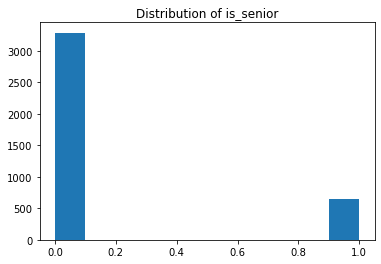

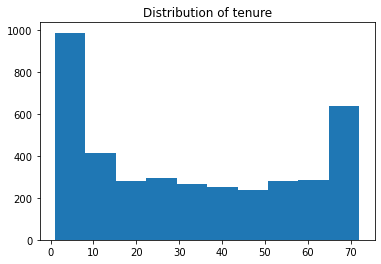

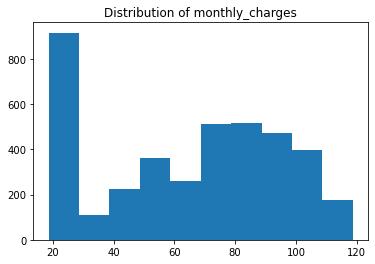

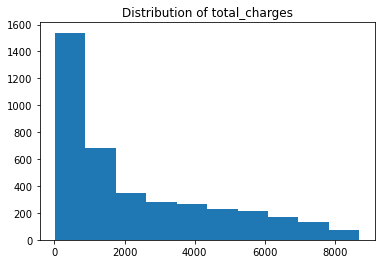

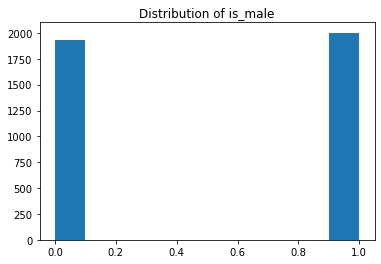

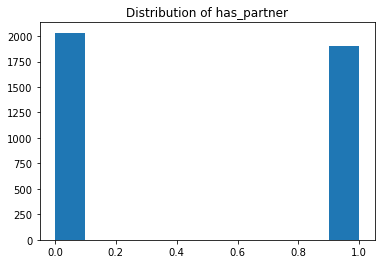

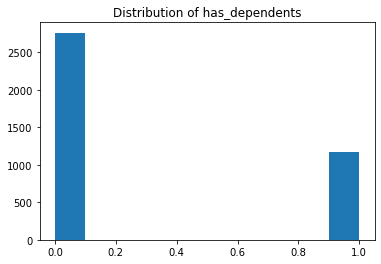

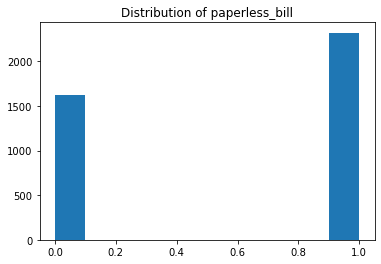

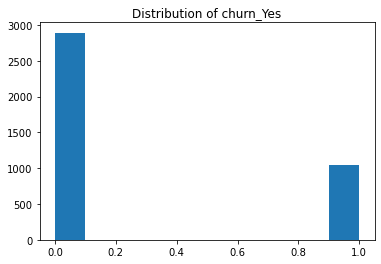

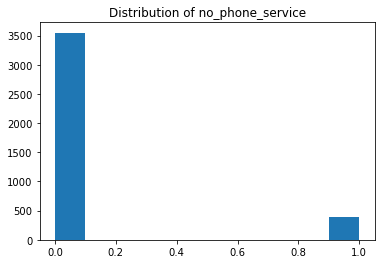

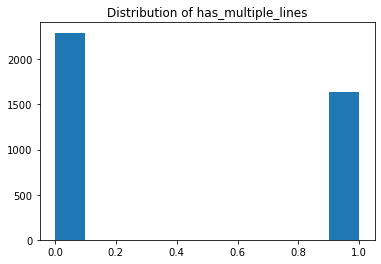

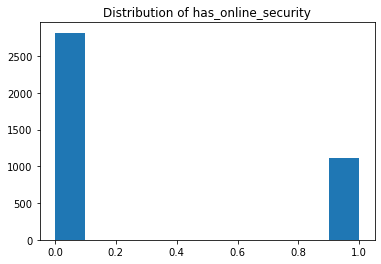

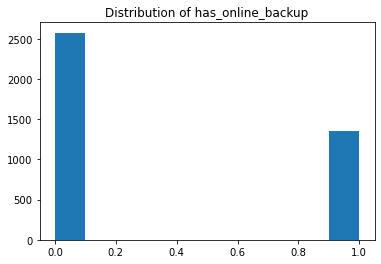

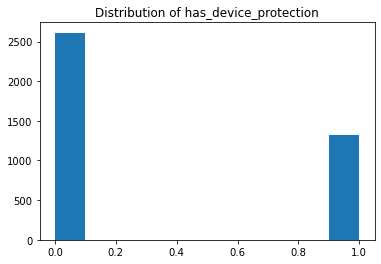

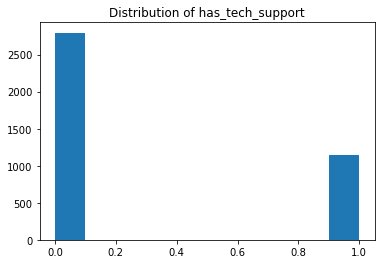

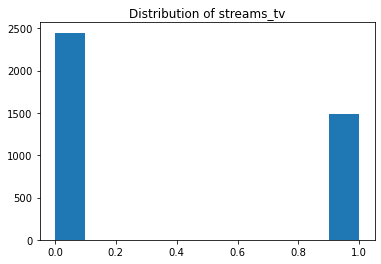

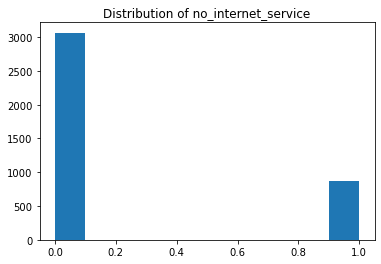

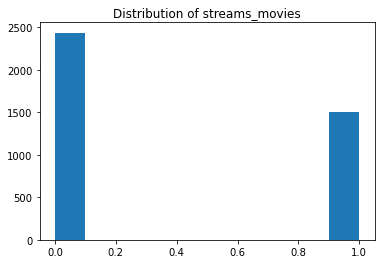

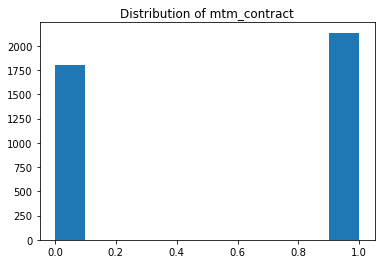

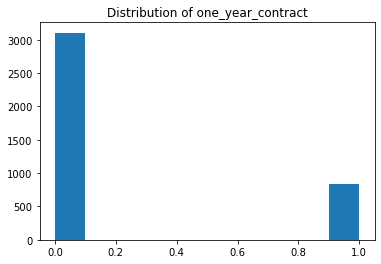

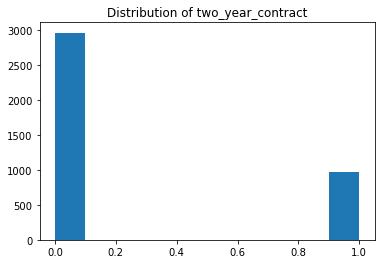

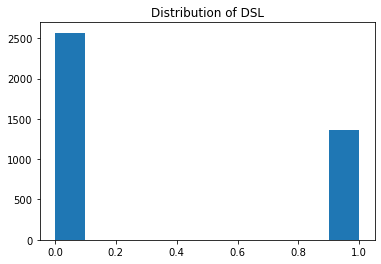

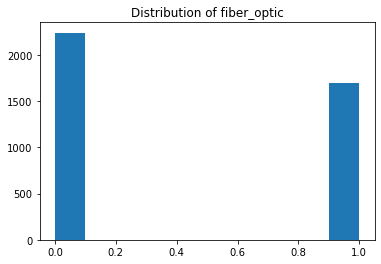

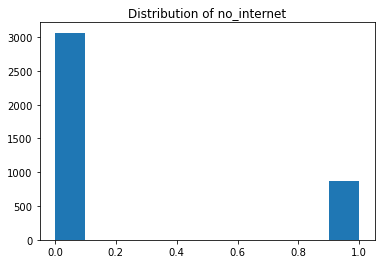

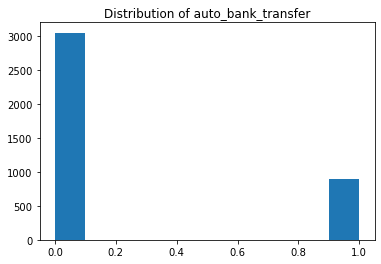

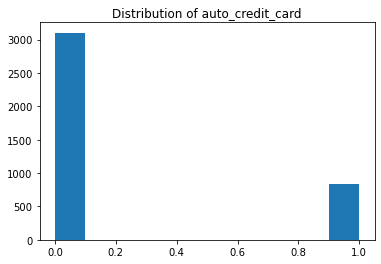

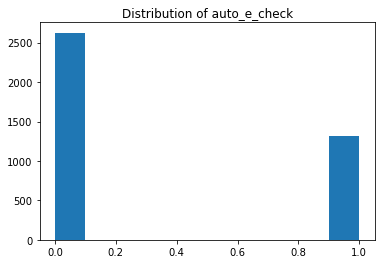

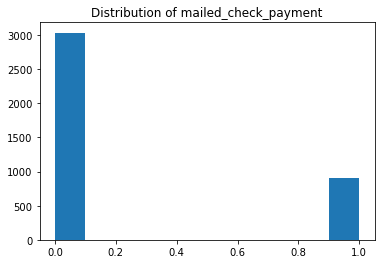

In [8]:
#I want to do a basic visualization of my features here:
num_distributions(train)

## Looking at distributions there are few takeaways:
1. More customers are NOT churning than churning.
2. Of internet_types, more customers have Fiber. Is there a relationship btw Internet_type and churn?
3. Of payment_types, more customers have e-check. Is there a relationship btw Payment_type and churn?
4. I'm curious about multiple lines. There is a slight majority of customers without multiple lines. Is there a relationship btw Multiple lines and churn?

## This brings me back to my initial hypotheses:
-does payment type have an impact on churn

-does having multiple lines have an impact on churn

-does internet_type have an impact on churn

## Hypotheses more formally stated as:
    
    -null hypothesis A: Payment_type has no impact, or is independent from churn
    -alternative hypothesis A: Payment_type is dependent on churn

    -null hypothesis B: Having multiple lines has no impact, or is independent from churn
    -alternative hypothesis B: Having multiple lines is dependent on churn

    -null hypothesis C: Internet_type has no impact, or is independent from churn
    -alternative hypothesis C: Internet_type is dependent on churn

## I'd like to do some statistical tests to further explore these hypotheses.

In [9]:
train.columns
#Looking at columns to separate into categorical and quantifiable variables.

Index(['is_senior', 'tenure', 'monthly_charges', 'total_charges', 'is_male',
       'has_partner', 'has_dependents', 'paperless_bill', 'churn_Yes',
       'no_phone_service', 'has_multiple_lines', 'has_online_security',
       'has_online_backup', 'has_device_protection', 'has_tech_support',
       'streams_tv', 'no_internet_service', 'streams_movies', 'mtm_contract',
       'one_year_contract', 'two_year_contract', 'DSL', 'fiber_optic',
       'no_internet', 'auto_bank_transfer', 'auto_credit_card', 'auto_e_check',
       'mailed_check_payment'],
      dtype='object')

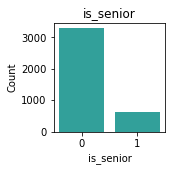

   is_senior  Count  Percent
0          0   3290    83.57
1          1    647    16.43
_________________________________________________________________


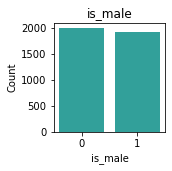

   is_male  Count  Percent
1        0   2002    50.85
0        1   1935    49.15
_________________________________________________________________


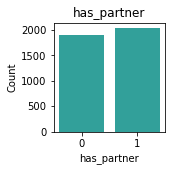

   has_partner  Count  Percent
0            1   2033    51.64
1            0   1904    48.36
_________________________________________________________________


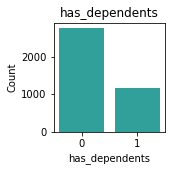

   has_dependents  Count  Percent
0               0   2764    70.21
1               1   1173    29.79
_________________________________________________________________


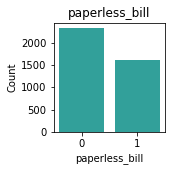

   paperless_bill  Count  Percent
1               0   2319     58.9
0               1   1618     41.1
_________________________________________________________________


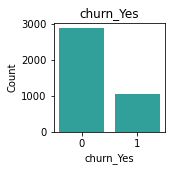

   churn_Yes  Count  Percent
0          0   2891    73.43
1          1   1046    26.57
_________________________________________________________________


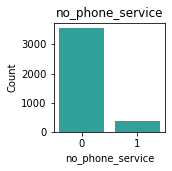

   no_phone_service  Count  Percent
0                 0   3548    90.12
1                 1    389     9.88
_________________________________________________________________


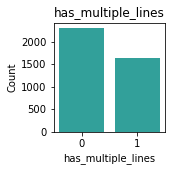

   has_multiple_lines  Count  Percent
0                   0   2295    58.29
1                   1   1642    41.71
_________________________________________________________________


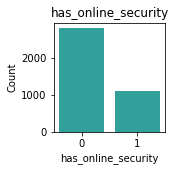

   has_online_security  Count  Percent
0                    0   2818    71.58
1                    1   1119    28.42
_________________________________________________________________


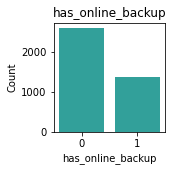

   has_online_backup  Count  Percent
0                  0   2578    65.48
1                  1   1359    34.52
_________________________________________________________________


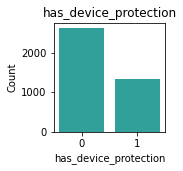

   has_device_protection  Count  Percent
0                      0   2611    66.32
1                      1   1326    33.68
_________________________________________________________________


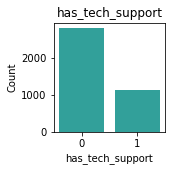

   has_tech_support  Count  Percent
0                 0   2795    70.99
1                 1   1142    29.01
_________________________________________________________________


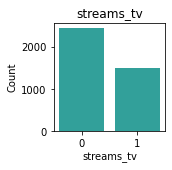

   streams_tv  Count  Percent
0           0   2448    62.18
1           1   1489    37.82
_________________________________________________________________


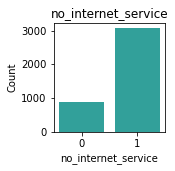

   no_internet_service  Count  Percent
0                    1   3066    77.88
1                    0    871    22.12
_________________________________________________________________


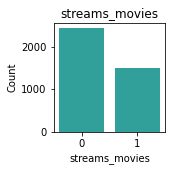

   streams_movies  Count  Percent
0               0   2436    61.87
1               1   1501    38.13
_________________________________________________________________


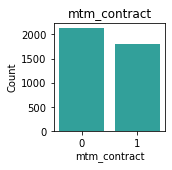

   mtm_contract  Count  Percent
1             0   2135    54.23
0             1   1802    45.77
_________________________________________________________________


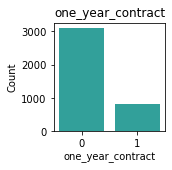

   one_year_contract  Count  Percent
0                  0   3107    78.92
1                  1    830    21.08
_________________________________________________________________


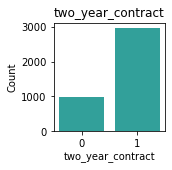

   two_year_contract  Count  Percent
0                  1   2965    75.31
1                  0    972    24.69
_________________________________________________________________


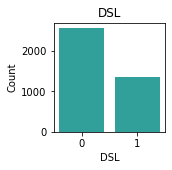

   DSL  Count  Percent
0    0   2569    65.25
1    1   1368    34.75
_________________________________________________________________


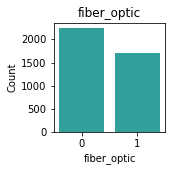

   fiber_optic  Count  Percent
0            0   2239    56.87
1            1   1698    43.13
_________________________________________________________________


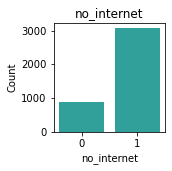

   no_internet  Count  Percent
0            1   3066    77.88
1            0    871    22.12
_________________________________________________________________


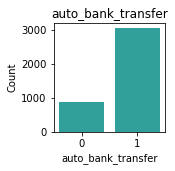

   auto_bank_transfer  Count  Percent
0                   1   3048    77.42
1                   0    889    22.58
_________________________________________________________________


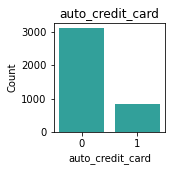

   auto_credit_card  Count  Percent
0                 0   3103    78.82
1                 1    834    21.18
_________________________________________________________________


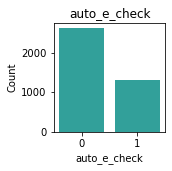

   auto_e_check  Count  Percent
0             0   2626     66.7
1             1   1311     33.3
_________________________________________________________________


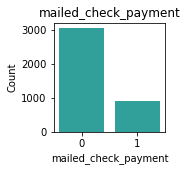

   mailed_check_payment  Count  Percent
0                     0   3034    77.06
1                     1    903    22.94
_________________________________________________________________


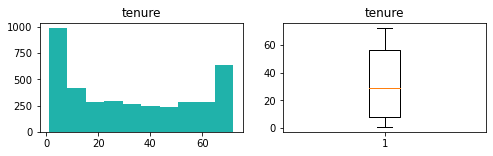

count    3937.000000
mean       32.505715
std        24.773712
min         1.000000
25%         8.000000
50%        29.000000
75%        56.000000
max        72.000000
Name: tenure, dtype: float64


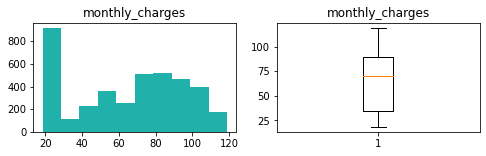

count    3937.000000
mean       64.191046
std        30.129425
min        18.550000
25%        34.950000
50%        69.950000
75%        89.450000
max       118.750000
Name: monthly_charges, dtype: float64


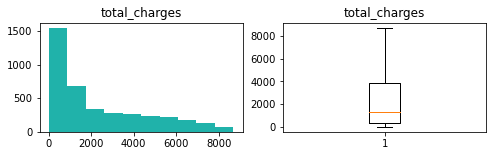

count    3937.000000
mean     2281.487668
std      2287.371123
min        18.800000
25%       371.400000
50%      1359.700000
75%      3827.900000
max      8684.800000
Name: total_charges, dtype: float64


In [10]:
cat_vars = ['is_senior',  'is_male',
       'has_partner', 'has_dependents', 'paperless_bill', 'churn_Yes',
       'no_phone_service', 'has_multiple_lines', 'has_online_security',
       'has_online_backup', 'has_device_protection', 'has_tech_support',
       'streams_tv', 'no_internet_service', 'streams_movies', 'mtm_contract',
       'one_year_contract', 'two_year_contract', 'DSL', 'fiber_optic',
       'no_internet', 'auto_bank_transfer', 'auto_credit_card', 'auto_e_check',
       'mailed_check_payment']
quant_vars = ['tenure', 'monthly_charges', 'total_charges',]

explore.explore_univariate(train, cat_vars, quant_vars)

## Key Takeaways from Univariate Statistics:
 
     -Churn: 73% of customers do NOT churn.  My baseline prediction will be that customers do NOT churn.
     
     -No categories stand out as being absolute drivers of churn yet.
     
     -I'm curious to see if anything jumps out when we look at the above in comparison to churn
     

## Moving forward with Explore and Bivariate Statistics: 

-I'll remove the variable churn_Yes from the cat_vars since it will be the target variable here.

has_multiple_lines 
_____________________

       chi2  p-value  degrees of freedom
0  5.568168  0.01829                   1

observed:
 churn_Yes              0     1   All
has_multiple_lines                  
0                   1718   577  2295
1                   1173   469  1642
All                 2891  1046  3937

expected:
              0           1
0  1685.254001  609.745999
1  1205.745999  436.254001


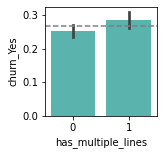


_____________________

mtm_contract 
_____________________

         chi2        p-value  degrees of freedom
0  673.238576  1.973847e-148                   1

observed:
 churn_Yes        0     1   All
mtm_contract                  
0             1682   120  1802
1             1209   926  2135
All           2891  1046  3937

expected:
              0           1
0  1323.236474  478.763526
1  1567.763526  567.236474


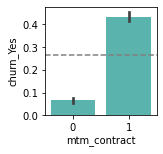


_____________________

one_year_contract 
_____________________

         chi2       p-value  degrees of freedom
0  140.547923  2.020214e-32                   1

observed:
 churn_Yes             0     1   All
one_year_contract                  
0                  2147   960  3107
1                   744    86   830
All                2891  1046  3937

expected:
              0           1
0  2281.518161  825.481839
1   609.481839  220.518161


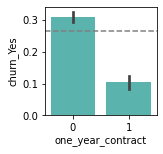


_____________________

two_year_contract 
_____________________

         chi2       p-value  degrees of freedom
0  350.536784  3.237781e-78                   1

observed:
 churn_Yes             0     1   All
two_year_contract                  
0                  1953  1012  2965
1                   938    34   972
All                2891  1046  3937

expected:
              0           1
0  2177.245364  787.754636
1   713.754636  258.245364


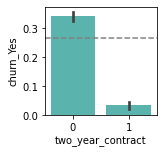


_____________________

DSL 
_____________________

        chi2       p-value  degrees of freedom
0  53.978347  2.027113e-13                   1

observed:
 churn_Yes     0     1   All
DSL                        
0          1789   780  2569
1          1102   266  1368
All        2891  1046  3937

expected:
              0           1
0  1886.456439  682.543561
1  1004.543561  363.456439


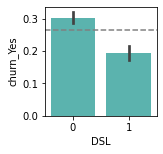


_____________________

fiber_optic 
_____________________

         chi2       p-value  degrees of freedom
0  370.972197  1.149523e-82                   1

observed:
 churn_Yes       0     1   All
fiber_optic                  
0            1909   330  2239
1             982   716  1698
All          2891  1046  3937

expected:
              0           1
0  1644.132334  594.867666
1  1246.867666  451.132334


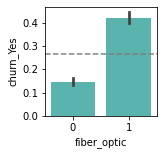


_____________________

no_internet 
_____________________

        chi2       p-value  degrees of freedom
0  210.52189  1.056829e-47                   1

observed:
 churn_Yes       0     1   All
no_internet                  
0            2084   982  3066
1             807    64   871
All          2891  1046  3937

expected:
              0           1
0  2251.411227  814.588773
1   639.588773  231.411227


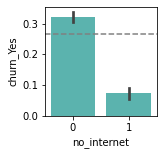


_____________________

auto_bank_transfer 
_____________________

        chi2       p-value  degrees of freedom
0  32.139949  1.434569e-08                   1

observed:
 churn_Yes              0     1   All
auto_bank_transfer                  
0                   2172   876  3048
1                    719   170   889
All                 2891  1046  3937

expected:
              0           1
0  2238.193548  809.806452
1   652.806452  236.193548


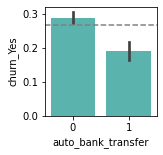


_____________________

auto_credit_card 
_____________________

        chi2       p-value  degrees of freedom
0  76.550586  2.146438e-18                   1

observed:
 churn_Yes            0     1   All
auto_credit_card                  
0                 2179   924  3103
1                  712   122   834
All               2891  1046  3937

expected:
              0           1
0  2278.580899  824.419101
1   612.419101  221.580899


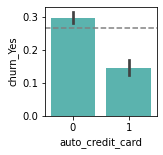


_____________________

auto_e_check 
_____________________

         chi2       p-value  degrees of freedom
0  335.348449  6.575305e-75                   1

observed:
 churn_Yes        0     1   All
auto_e_check                  
0             2168   458  2626
1              723   588  1311
All           2891  1046  3937

expected:
              0           1
0  1928.312421  697.687579
1   962.687579  348.312421


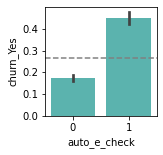


_____________________

mailed_check_payment 
_____________________

       chi2       p-value  degrees of freedom
0  39.69727  2.965397e-10                   1

observed:
 churn_Yes                0     1   All
mailed_check_payment                  
0                     2154   880  3034
1                      737   166   903
All                   2891  1046  3937

expected:
              0           1
0  2227.913132  806.086868
1   663.086868  239.913132


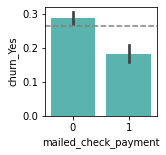


_____________________

tenure 
____________________



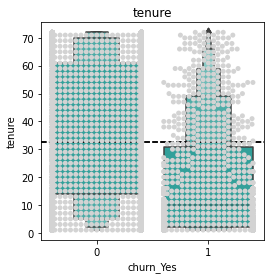

            count       mean        std  min   25%   50%    75%   max
churn_Yes                                                            
0          2891.0  37.583535  24.349023  1.0  14.0  37.0  61.00  72.0
1          1046.0  18.471319  20.088146  1.0   2.0  10.0  30.75  72.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2216535.5, pvalue=6.607556989659038e-111)

____________________

monthly_charges 
____________________



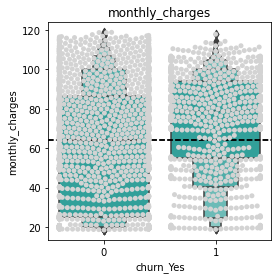

            count       mean        std    min   25%     50%   75%     max
churn_Yes                                                                 
0          2891.0  60.764182  31.116136  18.55  25.0  63.550  86.6  118.75
1          1046.0  73.662428  24.884594  18.85  55.2  79.075  94.0  117.80 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1151702.0, pvalue=2.727705309336549e-30)

____________________

total_charges 
____________________



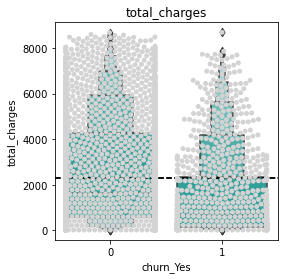

            count         mean          std    min      25%       50%  \
churn_Yes                                                               
0          2891.0  2547.079505  2348.789040  18.80  570.000  1651.950   
1          1046.0  1547.428394  1927.458468  18.85  134.775   666.575   

                75%      max  
churn_Yes                     
0          4252.100  8672.45  
1          2362.025  8684.80   


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1957884.0, pvalue=1.754576942195511e-45)

____________________



In [11]:
#Setting alpha at .05, or confidence level at 95%.  I will use the bivariate function to explore my hypotheses stated above.

#Instead of using all variables, only use the variables pertaining to my hypotheses for this portion of explore.

cat_vars = ['has_multiple_lines', 'mtm_contract',
       'one_year_contract', 'two_year_contract', 'DSL', 'fiber_optic',
       'no_internet', 'auto_bank_transfer', 'auto_credit_card', 'auto_e_check',
       'mailed_check_payment']


explore.explore_bivariate(train, 'churn_Yes', cat_vars, quant_vars)

## Key Takeaways from bivariate exploration:

-Multiple lines may have a relationship to churn
-More mtm customers churn than customers without mtm
-More fiber customers churn than customers without fiber
-More customers who pay with e-check churn than customers with other payment types

-With these takeaways, I will proceed with hypothesis testing statements.



## Hypothesis Testing Statements:

### Statements based on the above bivariate results.

    -null hypothesis A: Payment_type has no impact, or is independent from churn
    -alternative hypothesis A: Payment_type is dependent on churn
    -Results: p-value < .05 
    -In all three payment_type variables, we can reject the null hypothesis.

    -null hypothesis B: Having multiple lines has no impact, or is independent from churn
    -alternative hypothesis B: Having multiple lines is dependent on churn
    -Results: p-value < .05 
    -We can reject the null hypothesis.

    -null hypothesis C: Internet_type has no impact, or is independent from churn
    -alternative hypothesis C: Internet_type is dependent on churn
    -Results: p-value < .05 
    -For all internet_type variables, we can reject the null hypothesis.



## Based on the results of the hypothesis testing, we can move forward with our modeling.

### First I will establish a baseline accuracy.


In [12]:
train.churn_Yes.value_counts()
#Double checking to find the most common outcome for churn

0    2891
1    1046
Name: churn_Yes, dtype: int64

In [13]:
train['baseline_prediction'] = 0
train.head()
#Used 0 as the baseline prediction bc most customers do NOT churn.  Check head to be sure it's added to df.

,is_senior,tenure,monthly_charges,total_charges,is_male,has_partner,has_dependents,paperless_bill,churn_Yes,no_phone_service,...,one_year_contract,two_year_contract,DSL,fiber_optic,no_internet,auto_bank_transfer,auto_credit_card,auto_e_check,mailed_check_payment,baseline_prediction
6096,0,70,19.45,1303.50,0,1,0,0,0,0,...,0,1,0,0,1,1,0,0,0,0
1603,0,15,69.50,1071.40,1,1,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
5350,1,52,109.10,5647.95,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2068,0,39,40.60,1494.50,1,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,0
6366,0,32,19.30,593.20,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0


In [14]:
baseline_accuracy = (train.baseline_prediction == train.churn_Yes).mean()
print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 73.43%


## Now that I have baseline prediction with an accuracy of 73.43%, I'm ready to create a model.

### I will start with a decision_tree model.

In [15]:
#Create X and y labels for train, validate and test
X_train = train.drop(columns=['churn_Yes', 'baseline_prediction'])
y_train = train.churn_Yes

X_validate = validate.drop(columns=['churn_Yes'])
y_validate = validate.churn_Yes

X_test = test.drop(columns=['churn_Yes'])
y_test = test.churn_Yes

In [16]:
#Create the model:
clf = DecisionTreeClassifier(max_depth=5, random_state=123)

In [17]:
#Fit the model:

clf = clf.fit(X_train, y_train)

In [18]:
#Make prediction on train observations

y_pred = clf.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 0, 0], dtype=uint8)

In [19]:
#Show probability of predictions on train observations

y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.98552822, 0.01447178],
       [0.79672131, 0.20327869],
       [0.70491803, 0.29508197],
       [0.6779661 , 0.3220339 ],
       [0.97256098, 0.02743902]])

In [20]:
#Test the accuracy of the model

print('Accuracy of Decision Tree Classifier 1 on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree Classifier 1 on training set: 0.81


## The above model did about 8% better than the baseline prediction.
### Now, I want to create another Decision Tree Classifier with a greater depth.
### I will also create a visualization to see what features are most important in the model.




In [21]:
#Create the model:

clf2 = DecisionTreeClassifier(max_depth=8, random_state=123)

In [22]:
#Fit the model:

clf2 = clf2.fit(X_train, y_train)

In [23]:
dot_data = export_graphviz(clf2, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('Telco_Churn_decision_tree2', view=True)

'Telco_Churn_decision_tree2.pdf'

In [24]:
#Make prediction on train observations

y_pred = clf2.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 0, 0], dtype=uint8)

In [25]:
#Show probability of predictions on train observations

y_pred_proba = clf2.predict_proba(X_train)
y_pred_proba[0:5]

array([[1.        , 0.        ],
       [0.77222222, 0.22777778],
       [1.        , 0.        ],
       [0.65116279, 0.34883721],
       [0.97142857, 0.02857143]])

In [26]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf2.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.85


## Accuracy didn't increase much by adding more depth.
### I will try another model.

In [27]:
#Going to use the Random Forest since it weighs the importance of features

#Create the rf object:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [28]:
#Fit the model to our Train dataset:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=123)

In [29]:
print(rf.feature_importances_)

[0.0182495  0.15864409 0.1312996  0.14313285 0.01756039 0.01469886
 0.01512859 0.02259811 0.00649002 0.01384018 0.03075224 0.0140874
 0.01229537 0.02133783 0.01237599 0.02005738 0.01365678 0.11682085
 0.01789818 0.03567289 0.01771763 0.05369958 0.02037543 0.00905642
 0.01189035 0.04031587 0.01034763]


In [30]:
print(X_train.columns)

Index(['is_senior', 'tenure', 'monthly_charges', 'total_charges', 'is_male',
       'has_partner', 'has_dependents', 'paperless_bill', 'no_phone_service',
       'has_multiple_lines', 'has_online_security', 'has_online_backup',
       'has_device_protection', 'has_tech_support', 'streams_tv',
       'no_internet_service', 'streams_movies', 'mtm_contract',
       'one_year_contract', 'two_year_contract', 'DSL', 'fiber_optic',
       'no_internet', 'auto_bank_transfer', 'auto_credit_card', 'auto_e_check',
       'mailed_check_payment'],
      dtype='object')


## The most important features according to this model are: 
    Tenure, Monthly & Total Charges, MTM Contract, Fiber Optic, ECheck. 

In [31]:
y_pred = rf.predict(X_train)

In [32]:
y_pred_proba = rf.predict_proba(X_train)

In [33]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.89


## This model does better than the other two Decision Tree Classifiers, and just over 15% better than the baseline prediction.

In [34]:
print(confusion_matrix(y_train, y_pred))

[[2747  144]
 [ 282  764]]


#### The matrix here represent the 4 possible outcomes of our classification task:

#### [0,0]: There are 2747 True Negatives, where we predicted a customer would not churn and customer did not churn

#### [0:1]: There is 144 False Positive, where we predicted a customer would churn, but did not

#### [1,0]: There are 282 False Negatives, where we predicted those people did not churn, but they did

#### [1,1]: There are 764 True Positives, where we predicted customers did churn and they did 

In [35]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2891
           1       0.84      0.73      0.78      1046

    accuracy                           0.89      3937
   macro avg       0.87      0.84      0.86      3937
weighted avg       0.89      0.89      0.89      3937



## Now, we are ready to validate and test this model.


In [36]:
#Create the rf object:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [37]:
rf.fit(X_validate, y_validate)

RandomForestClassifier(max_depth=10, random_state=123)

In [38]:
print(rf.feature_importances_)

[0.01647714 0.16170514 0.13746513 0.16811195 0.02500373 0.0200324
 0.0167759  0.02737206 0.00681031 0.01914709 0.01594099 0.01976726
 0.0179065  0.02222688 0.0152158  0.00947902 0.0184608  0.08293491
 0.01549909 0.02566496 0.01489732 0.05278266 0.00960284 0.01433335
 0.01128844 0.04009305 0.01500527]


In [39]:
y_pred = rf.predict(X_validate)

In [40]:
y_pred_proba = rf.predict_proba(X_validate)

In [41]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on training set: 0.94


In [42]:
rf.fit(X_test, y_test)

RandomForestClassifier(max_depth=10, random_state=123)

In [43]:
print(rf.feature_importances_)

[0.02105839 0.17258257 0.14114643 0.16229997 0.01975816 0.02062949
 0.02233405 0.02607761 0.00550447 0.01998104 0.02285422 0.01670559
 0.01749853 0.01808217 0.01706467 0.01333612 0.01713387 0.06933204
 0.01557785 0.03131528 0.01397558 0.03576761 0.01513103 0.01130565
 0.01154913 0.05103429 0.01096418]


In [44]:
y_pred = rf.predict(X_test)

In [45]:
y_pred_proba = rf.predict_proba(X_test)

In [46]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on training set: 0.96


# Now that the modeling is complete: Key Takeaways & Summary:

    -While most customers will not churn, the customers who will likely churn are:
        -Customers with Month-to-Month contracts, Fiber Optic Internet and E-checks
        -Further exploring and testing is needed to find the aspects of Tenure, Monthly Charges and Total Charges since our model does not give us that specific information
        
    -Moving forward,my recommendation is to be sure that customers actually the features above: month to month contracts, Fiber Optic Internet and E-check
    -With more time, I would like to explore the aspects of tenure and charges, and control for features to get an even more accurate picture of what is driving churn.